In [12]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import json

from types import SimpleNamespace

from utils.dataloader import get_dataloaders
from utils.utils import get_model, project_bin_mask
from utils.mlp_mixer import create_binary_mask

In [26]:
args = SimpleNamespace()
args.dataset = 'c10'
args.model = 'mlp_mixer_masked'
args.batch_size = 256
args.eval_batch_size = 256
args.num_workers = 4
args.seed = 0
args.epochs = 300
args.patch_size = 16
args.ps = 16
args.autoaugment = False
args.use_cuda = True
args.size = 224
args.split = 'index'
args.hidden_size = 128
args.hidden_c = 512
args.hidden_s = 64
args.num_layers = 8
args.num_classes = 10
args.drop_p = 0
args.off_act = False
args.is_cls_token = False
args.lambda_drop = 0.3
args.attn_maps_path = './utils/avg_attns_trainset.json'
args.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
with open(args.attn_maps_path) as json_file:
    args.data = json.load(json_file)

In [15]:
train_dataloader, test_dataloader = get_dataloaders(args)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
model = get_model(args)
model1 = get_model(args)

In [17]:
model.load_state_dict(torch.load('../artifacts/mixer_masked_cifar10_0.0.pth'))
model1.load_state_dict(torch.load('../artifacts/mixer_masked_cifar10_0.2.pth'));

In [18]:
@torch.no_grad()
def evaluate_validation(model, loader, device):
    loss_fcn = nn.CrossEntropyLoss()
    total_loss, total_acc, num_imgs = 0.0, 0.0, 0.0
    for img, label in loader:
        img, label = img.to(device), label.to(device)
        projected_mask = torch.ones_like(model.patch_emb(img)).to(device)
        out, _ = model(img, projected_mask)
        loss = loss_fcn(out, label)
        total_loss += loss
        total_acc += out.argmax(dim=-1).eq(label).sum(-1)
        num_imgs += img.size(0)
    return total_loss/num_imgs, total_acc/num_imgs

In [19]:
@torch.no_grad()
def evaluate_training(model, loader, device, args):
    loss_fcn = nn.CrossEntropyLoss()
    total_loss, total_acc, num_imgs = 0.0, 0.0, 0.0
    for img, label, index in loader:
        img, label = img.to(device), label.to(device)
        projected_mask = project_bin_mask(img, index, args.data, args.lambda_drop, args.ps, img.shape[1], args.hidden_size)
        projected_mask = create_binary_mask(projected_mask).to(device)

        out, _ = model(img, projected_mask)
        loss = loss_fcn(out, label)
        total_loss += loss
        total_acc += out.argmax(dim=-1).eq(label).sum(-1)
        num_imgs += img.size(0)
    return total_loss/num_imgs, total_acc/num_imgs

In [20]:
xsweep = np.linspace(0,1,10)

In [21]:
def interpolate_validation_models(model, model1, loader, args, xsweep):
    interpolation_loss = []
    interpolation_acc = []

    loss, acc = evaluate_validation(model, loader, args.device)
    loss1, acc1 = evaluate_validation(model1, loader, args.device)

    for alpha in xsweep:
        interp_loss = alpha * loss.item() + (1 - alpha) * loss1.item()
        interp_acc = alpha * acc.item() + (1 - alpha) * acc1.item()
        interpolation_loss.append(interp_loss)
        interpolation_acc.append(interp_acc)

    return np.array(interpolation_loss), np.array(interpolation_acc)

In [27]:
training_loss, training_acc = evaluate_training(model, train_dataloader, args.device, args)

In [28]:
training_loss

tensor(0.0014, device='cuda:0')

In [29]:
training_acc

tensor(0.9166, device='cuda:0')

In [67]:
iloss_test, iacc_test = interpolate_validation_models(model, model1, test_dataloader, args, xsweep)

[Text(0.5, 0, 'alpha'), Text(0, 0.5, 'Accuracy')]

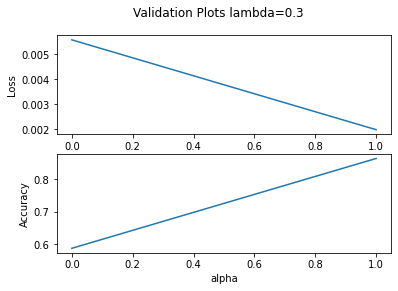

In [68]:
fig, axs = plt.subplots(2)
fig.suptitle('Validation Plots lambda=0.3')
axs[0].plot(xsweep, iloss_test)
axs[0].set(ylabel='Loss')
axs[1].plot(xsweep, iacc_test)
axs[1].set(xlabel='alpha', ylabel='Accuracy')

In [72]:
iloss_train, iacc_train = interpolate_models(model, model1, train_dataloader, args, xsweep, None)

[Text(0.5, 0, 'alpha'), Text(0, 0.5, 'Accuracy')]

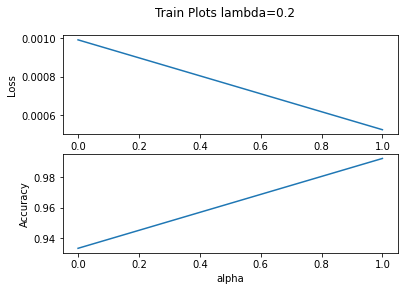

In [73]:
fig, axs = plt.subplots(2)
fig.suptitle('Train Plots lambda=0.2')
axs[0].plot(xsweep, iloss_train)
axs[0].set(ylabel='Loss')
axs[1].plot(xsweep, iacc_train)
axs[1].set(xlabel='alpha', ylabel='Accuracy')